# Practical session n°3

Notions:
- Training from scratch
- Validation step
- Learning curves
- Transfer learning
- Fine tuning
- Freezing

Duration: 2 h

Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on slightly more challenging problems than separation of points in a 2D space:
- handwritten digit recognition (part **I.**)
- binary classification of photos (part **II.**)

The first machine learning problem will give us the opportunity to train a tiny CNN from scratch through a complete training loop (including training and validation steps).
An efficient training from scratch on the second problem would need much more images than the few available photos (200). We hence use one of the most interesting features of the neural networks: once trained on a very big dataset on a very general task, they could be "retrained" (one says fine tuned) on a very specific task that share the same inputs. As such pretrained neural network are much bigger than our first tiny CNN, a graphics card will be used to significantly speed up the process.

### **I.A.** The MNIST Database of Handwritten Digit

The Database of Handwritten Digit of the NIST (National Institute of Standards and Technologogies) comprises 70,000 black and white  images of handwritten digits of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. \\
The subsequent cells are designed to import packages, download the MNIST database, define dataLoaders and showcase some images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [2]:
# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])

# Definition of training sets:
trainval_dataset = datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=tr)

# Split indices for training and validation
num_images = len(trainval_dataset)
indices = list(range(num_images))
split = int(np.floor(0.2 * num_images))  # 20% validation

# Shuffle indices
np.random.seed(42)  # Seed for reproducibility
np.random.shuffle(indices)

# Create train and validation samplers
train_indices, val_indices = indices[split:], indices[:split]

from torch.utils.data import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_size = len(train_sampler)
val_size = len(val_sampler)

# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

train_loader = DataLoader(trainval_dataset, batch_size=bs,
                          sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(trainval_dataset, batch_size=bs,
                        sampler=val_sampler, num_workers=num_workers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.14MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.7kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.05MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([8, 1, 28, 28])


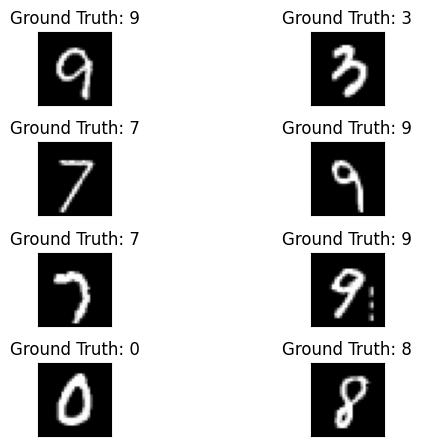

In [3]:
x, t = next(iter(train_loader))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])

**Exercise 1**:
- Are images sampled by train_loader and val_loader normalized?
- How much images are in *train_loader* and *val_loader*?
- What will be the role of the validation loader?

### **I.B.** A vanilla CNN

Now, we will define a vanilla CNN with two convolution layers.

**Exercise 2:**  Determine *N* in such a way that the network can accept MNIST images as input.
How outputs will be interpreted after the training ?

In [4]:
N = 490

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # convert an image to a 1D torch.tensor:
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### **I.C.** Training of the CNN

To train a CNN, let's define a loss function. Since the log of output probabilities has been computed with *F.log_softmax*, we only need to gather the logits associated with the target classes. This can be done with the torch.gather function (see **P1**), but the standard way in PyTorch is to use *torch.nn.NLLLoss()*.

In [5]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# NLLLoss() will have the same effect as torch.gather (see TP1)
loss_fn =  torch.nn.NLLLoss()

A complete training loop has (at least) two phases: weights are updated only in the first phase dedicated to training. During the validation phase, **generalization performance** on independent images is monitored.

**Exercise 3**:
Complete the following code to print the mean loss and the accuracy on the train and validation sets.


In [7]:
train_losses = []
val_losses = []

train_accs = []
val_accs = []

### BEGIN SOLUTION

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')


### END SOLUTION

epoch :0
train Loss: 0.1933 Acc: 0.9402
val Loss: 0.0634 Acc: 0.9816
Time: 56 seconds
epoch :1
train Loss: 0.0552 Acc: 0.9834
val Loss: 0.0581 Acc: 0.9815
Time: 113 seconds
epoch :2
train Loss: 0.0411 Acc: 0.9875
val Loss: 0.0533 Acc: 0.9855
Time: 173 seconds
epoch :3
train Loss: 0.0353 Acc: 0.9893
val Loss: 0.0620 Acc: 0.9834
Time: 227 seconds
epoch :4
train Loss: 0.0286 Acc: 0.9912
val Loss: 0.0477 Acc: 0.9888
Time: 287 seconds
epoch :5
train Loss: 0.0254 Acc: 0.9924
val Loss: 0.0493 Acc: 0.9863
Time: 344 seconds


**Exercise 4**:
At each epoch, store the accuracy and the cost function value in the lists *train_losses*, *val_losses*, *train_accs*, and *val_accs*.
Plot the **learning curves** over six epochs. \\

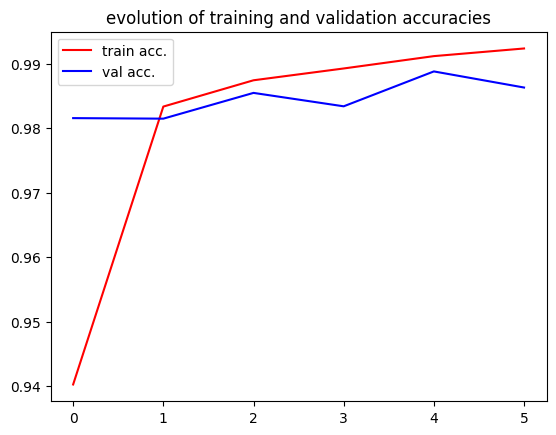

In [11]:
fig, ax = plt.subplots()
plt.title('evolution of training and validation accuracies')
ax.plot(np.arange(6), np.array(train_accs), color = 'r')
ax.plot(np.arange(6), np.array(val_accs), color = 'b')
ax.legend(['train acc.', 'val acc.'])

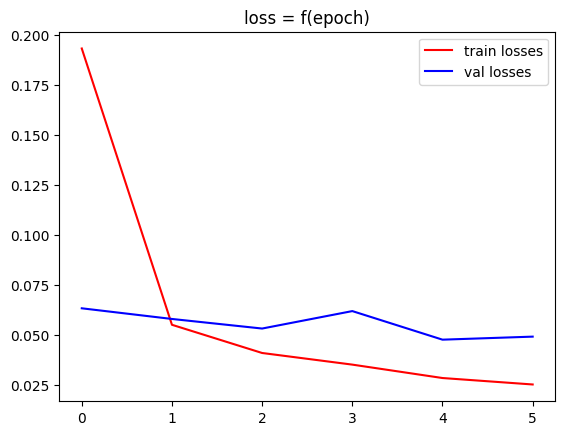

In [13]:
fig2, ax2 = plt.subplots()

plt.title('loss = f(epoch)')
ax2.plot(np.arange(6), np.array(train_losses), color = 'r')
ax2.plot(np.arange(6), np.array(val_losses), color = 'b')
ax2.legend(['train losses', 'val losses'])

**Exercise 5:** Complete the following perceptron (P60) to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance on a test set.

In [28]:
class P60(nn.Module):

    def __init__(self):
        super(P60, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)  # 28*28 numel of MNIST images
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # flattening x
        x = x.view(-1, 28*28)

        # apply first layer
        x = F.relu(self.fc1(x))

        # apply second layer
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

perceptron = P60()
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

In [29]:
# Size comparison:

# CNN (don't forget the scalar biases, present by default):
print("CNN: \n")
print(" nb of parameters (conv) : " + str(10*1*5*5 + 10 + 10*10*5*5 + 10))
print(" nb of parameters (fc) : " + str(490*50 + 50 + 50*10 + 10))
print(" total: " + str(10*1*5*5 + 10 + 10*10*5*5 + 10 + \
                        490*50 + 50 + 50*10 + 10))

CNN: 

 nb of parameters (conv) : 2770
 nb of parameters (fc) : 25060
 total: 27830


In [30]:
# Verification:
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif : " + str(nb_weights))
print("\n")

verif : 27830




In [31]:
# Perceptron P60:
print("P60: \n")
print("nb of parameters (fc) : " + str(28*28*50 + 50 + 50*10 + 10))

# Verification:
nb_weights = 0
for module in perceptron.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("verif: " + str(nb_weights))

# There are more parameters (weights) in the perceptron.

P60: 

nb of parameters (fc) : 39760
verif: 39760


In [32]:
# Training the perceptron

train_losses = []
val_losses = []

train_accs = []
val_accs = []



# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = perceptron(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

epoch :0
train Loss: 0.5755 Acc: 0.8154
val Loss: 0.4638 Acc: 0.8537
Time: 33 seconds
epoch :1
train Loss: 0.4328 Acc: 0.8625
val Loss: 0.4150 Acc: 0.8696
Time: 66 seconds
epoch :2
train Loss: 0.4096 Acc: 0.8700
val Loss: 0.4040 Acc: 0.8685
Time: 97 seconds
epoch :3
train Loss: 0.3865 Acc: 0.8763
val Loss: 0.4090 Acc: 0.8780
Time: 131 seconds
epoch :4
train Loss: 0.3786 Acc: 0.8782
val Loss: 0.3888 Acc: 0.8795
Time: 164 seconds
epoch :5
train Loss: 0.3660 Acc: 0.8835
val Loss: 0.3885 Acc: 0.8815
Time: 198 seconds


In [33]:
# Definition of the test set:
test_dataset = datasets.MNIST(root='./data',
                                  train=False,
                                  download=True,
                                  transform=tr)

# Note that our test test corresponds to the official MNIST validation step
num_images = len(test_dataset)
print(f"number of images in the test set: {num_images}")


# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

test_loader = DataLoader(test_dataset, batch_size=bs,
                         num_workers=num_workers)


number of images in the test set: 10000


In [34]:
# Performance comparison (on a test set):

test_accs_cnn = []
test_accs_perceptron = []
model.eval()
perceptron.eval()

# Testing Loop (only one epoch is needed)
for epoch in range(1):
    print('epoch :' + str(epoch))

    running_corrects_test_cnn = 0.
    running_corrects_test_perceptron = 0.

    # Training
    for x, label in test_loader:
      with torch.no_grad():
        output = model(x)
        # Counters:
        _, preds = torch.max(output, 1)
        running_corrects_test_cnn += torch.sum(preds == label.data)

        output = perceptron(x)
        # Counters:
        _, preds = torch.max(output, 1)
        running_corrects_test_perceptron += torch.sum(preds == label.data)

    # Calculate scores and store:
    epoch_acc_test_cnn = running_corrects_test_cnn.float() / len(test_dataset)
    epoch_acc_test_perceptron = running_corrects_test_perceptron.float() / len(test_dataset)


    print('{} Acc. cnn: {:.4f} Acc perceptron: {:.4f}'.format(
        'train', epoch_acc_test_cnn, epoch_acc_test_perceptron))

epoch :0
train Acc. cnn: 0.9885 Acc perceptron: 0.9509


### **II.A.** Load and viz the Hymenoptera dataset:

Through a second image classification problem, we focus on two other important aspects of deep learning: speeding up the learning with GPU cards and the ability to use pretrained networks.

To illustrate the first aspect, we will use the GPUs available under Google Colab. To do this, before starting this part, go to **Modifier**/**Modifier les param du notebook** and select a GPU.

In [35]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print(torch.cuda.get_device_name(device))
else:
  print('Change the runtime type to GPU')

Tesla T4


Now let's download inputs (RGB images of bees or ants) and targets ("bee" or "ant").

In [36]:
# download the dataset
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -qq hymenoptera_data.zip

--2024-12-06 08:26:06--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.31, 3.165.102.62, 3.165.102.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2024-12-06 08:26:06 (345 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [37]:
dir_data = 'hymenoptera_data'
print(os.listdir(dir_data))

['val', 'train']


The dataset is in a standard format, and we can manipulate it with a ready-to-use dataset object of the datasets.ImageFolder class:

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Dataset sizs:' )
print(dataset_sizes)

Dataset sizs:
{'train': 244, 'val': 153}


Since the provided dataset is very small, we need to maximize its utility. We will produce new images through additional transformations that preserve the nature of the object (data augmentation). \\
In the code, transforms.*RandomResizedCrop()*, *transforms.RandomHorizontalFlip()* and *transforms.RandomVerticalFlip()* apply horizontal or vertical axis symmetry with a probability of 1/2. Note that these transformations might not be suitable for other datasets like MNIST since the mirror image of a digit is generally not another digit. \\
Some images are presented below.

In [39]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      plt.imshow(inp)
      plt.title(title)
    else:
      ax.imshow(inp)
      ax.set_title(title)

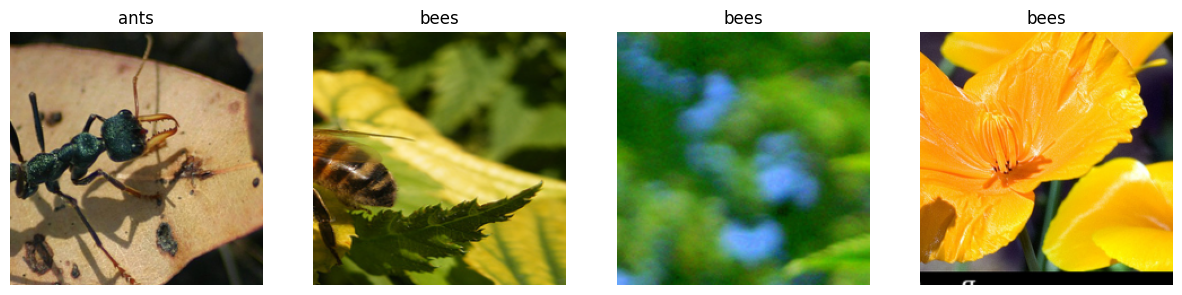

In [40]:
def plot_batch(images, labels, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axs[i].axis('off')
        imshow(images[i],axs[i],class_names[labels[i]])
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
# Assuming `inputs` is a batch of images and `classes` are the corresponding class labels
plot_batch(inputs, classes, class_names)

### **II.B.** Using a Graphics Card:

In this part, the lightest of the ResNet architectures is adapted to our binary classification problem and trained over one epoch.

**Exercise 6:**

- Load an untrained ResNet18. How many total weights does it contain? Check [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

- How many neurons does the last layer of the network have?

- Is there a softmax operation at the end of *ResNet.forward()*?

- Modify the last layer of the classifier so that it has as many neurons as there are classes in hymenoptera_data.

In [41]:
model = models.resnet18(pretrained=False)

print(model)
nb_weights = 0
for module in model.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)\
                                   or isinstance(module, nn.BatchNorm2d):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print(nb_weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
# Neurons in the last layer
print(model.fc)
print(model.fc.out_features, "neurons")
# 1000 neurons

Linear(in_features=512, out_features=1000, bias=True)
1000 neurons


In [43]:
# Modification of the last layer of the classifier
def get_model(pretrained):
  model = models.resnet18(pretrained=pretrained)

  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  return model

Now, let's define the negative log-likelihood as the cost function. To compute the log-likelihood, we could add a LogSoftmax layer to the ResNet. Another common way to do that is to use a loss function that includes *LogSoftmax*. In this regard, in PyTorch,  *nn.CrossEntropyLoss* combines both *LogSoftmax* and *NLLLoss*.

In [44]:
loss_fn = nn.CrossEntropyLoss()

Finally, let's define a function that incorporates the training loop:

In [45]:
def train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

**Exercise 7:** With the *train_model* function, train the ResNet over one epoch with mini-batches of 64 images.

In [46]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

model = get_model(pretrained=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training over 1 epoch:
model = train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.7070 Acc: 49.18%
val Loss: 0.6908 Acc: 52.94%
Training complete in 0m 58s


### **II.C.** Using a Graphics Card:

With more than 10 million parameters, training a ResNet18 on a CPU is much slower than the networks in Part I. \\
Let's repeat the same training using the GPU.

In [47]:
print(f'Runtime device :{device}')

# Load the model to the GPU:
model = model.to(device)

Runtime device :cuda:0


To load a torch.tensor on GPU, the syntax is the same:

In [48]:
x = torch.rand(2,1,4,4)
print("On CPU :\n",x)
x = x.to(device)
# Note: You can also use .cuda() without specifying the device name
# but this method is not recommended especially in a multi-gpu environment
print("On GPU :\n",x)

# bring back the x tensor to the CPU RAM:
x = x.to('cpu') # or x.cpu()
print('Back to CPU:\n',x)

On CPU :
 tensor([[[[0.1205, 0.5174, 0.1828, 0.4908],
          [0.0753, 0.9754, 0.6842, 0.3403],
          [0.8898, 0.0833, 0.2539, 0.0401],
          [0.4943, 0.5890, 0.6505, 0.2341]]],


        [[[0.4587, 0.8206, 0.1067, 0.4394],
          [0.8895, 0.6546, 0.1444, 0.6597],
          [0.7249, 0.6154, 0.6560, 0.5960],
          [0.1373, 0.9457, 0.6620, 0.5156]]]])
On GPU :
 tensor([[[[0.1205, 0.5174, 0.1828, 0.4908],
          [0.0753, 0.9754, 0.6842, 0.3403],
          [0.8898, 0.0833, 0.2539, 0.0401],
          [0.4943, 0.5890, 0.6505, 0.2341]]],


        [[[0.4587, 0.8206, 0.1067, 0.4394],
          [0.8895, 0.6546, 0.1444, 0.6597],
          [0.7249, 0.6154, 0.6560, 0.5960],
          [0.1373, 0.9457, 0.6620, 0.5156]]]], device='cuda:0')
Back to CPU:
 tensor([[[[0.1205, 0.5174, 0.1828, 0.4908],
          [0.0753, 0.9754, 0.6842, 0.3403],
          [0.8898, 0.0833, 0.2539, 0.0401],
          [0.4943, 0.5890, 0.6505, 0.2341]]],


        [[[0.4587, 0.8206, 0.1067, 0.4394],
       

**Exercise 8:**
- Complete the fonction *train_model_gpu* to train the model on GPU.
- Compare the CPU and GPU training times.
- What are the validation scores after 20 epochs on GPUs ?

In [49]:
def train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    # Record the starting time
    since = time.time()
    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                labels = labels.to(device)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    # Calculate and print the total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # Return the trained model
    return model

In [50]:
model = get_model(pretrained=False).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model = train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.6896 Acc: 49.59%
val Loss: 0.6707 Acc: 62.09%
Training complete in 0m 5s


### **II.D.** Impact of pretraining on performance:

Training is faster on a GPU, but it only leads to a very poor score, barely better than random chance. To improve performance, a simple idea is to use a network trained on a similar (or more general) task as a starting point for learning. Here, it works particularly well with networks trained on ImageNet, whose convolutional filters are already very rich.

**Note:**
This method is refered to as **fine-tuning** a **pretrained model**.

**Exercise 9:** Compare two ResNet18 trainings, one randomly initialized and the other pre-trained, using learning curves, over 25 epochs.

In [51]:
def train_model_gpu_(dataloaders, model, loss_fn, optimizer, num_epochs=1):

    train_accs = []
    val_accs = []

    # Loop through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Iterate through training and validation phases
        for phase in ['train', 'val']:
            # Set the model to training mode during the training phase, and evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize counters for loss and correct predictions
            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches in the data loader
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the specified device (GPU)
                ### BEGIN SOLUTION
                inputs = inputs.to(device)
                labels = labels.to(device)
                ### END SOLUTION

                # Zero the gradients in the optimizer (same as in train_model())
                ### BEGIN SOLUTION
                optimizer.zero_grad()
                ### END SOLUTION
                # Forward pass: compute model outputs and predictions (same as in train_model())
                with torch.set_grad_enabled(phase == 'train'):
                    ### BEGIN SOLUTION
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    ### END SOLUTION
                    # Backward pass and optimization step if in the training phase (same as in train_model())
                    ### BEGIN SOLUTION
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    ### END SOLUTION
                # Update counters
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                # The 'acc' tensor is distributed across different parts of the GPU
                # Gather the 'acc' tensor on the CPU before accumulation
                # running_corrects += ...
                ### BEGIN SOLUTION
                running_corrects += acc.cpu()
                ### END SOLUTION

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =='train':
              train_accs.append(epoch_acc)
            elif phase =='val':
              val_accs.append(epoch_acc)

            # Print epoch statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')


    # Return the trained model, train_accs and val_accs
    return model, train_accs, val_accs

In [52]:
max_epochs = 25
# Learning "from scratch" (random weights) :
# get the model
# Put the model on GPU
# get the loss, optimize, the scheduler and starting the training
# ...
# resnet_scratch, accs_scratch = train(...)

resnet_scratch = get_model(pretrained=False)
resnet_scratch = resnet_scratch.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_scratch.parameters(), lr=0.001,
                            momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
resnet_scratch, _, accs_scratch =  train_model_gpu_(dataloaders,
                                                    resnet_scratch,
                                                    loss_function,
                                                    optimizer,
                                                    num_epochs=max_epochs)



Epoch 0/24
----------
train Loss: 0.6948 Acc: 50.00%
val Loss: 0.6801 Acc: 62.75%
Epoch 1/24
----------
train Loss: 0.6672 Acc: 57.79%
val Loss: 0.6840 Acc: 54.90%
Epoch 2/24
----------
train Loss: 0.6462 Acc: 64.75%
val Loss: 0.6886 Acc: 47.06%
Epoch 3/24
----------
train Loss: 0.6559 Acc: 63.11%
val Loss: 0.6980 Acc: 47.06%
Epoch 4/24
----------
train Loss: 0.6302 Acc: 62.30%
val Loss: 0.6622 Acc: 57.52%
Epoch 5/24
----------
train Loss: 0.6090 Acc: 66.39%
val Loss: 0.6378 Acc: 65.36%
Epoch 6/24
----------
train Loss: 0.6087 Acc: 67.62%
val Loss: 0.6396 Acc: 61.44%
Epoch 7/24
----------
train Loss: 0.6021 Acc: 68.44%
val Loss: 0.6128 Acc: 67.97%
Epoch 8/24
----------
train Loss: 0.6008 Acc: 67.62%
val Loss: 0.6016 Acc: 69.28%
Epoch 9/24
----------
train Loss: 0.5648 Acc: 68.85%
val Loss: 0.5966 Acc: 71.24%
Epoch 10/24
----------
train Loss: 0.5540 Acc: 66.80%
val Loss: 0.5863 Acc: 73.86%
Epoch 11/24
----------
train Loss: 0.5672 Acc: 70.49%
val Loss: 0.5794 Acc: 71.90%
Epoch 12/24
--

In [55]:
# fine tuning a pretrained model:
# ...
# resnet_ft, accs_ft = train(...)

resnet_ft = get_model(pretrained=True)

resnet_ft = resnet_ft.to(device)

optimizer = torch.optim.SGD(resnet_ft.parameters(), lr=0.001,
                            momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
resnet_ft, _, accs_ft = train_model_gpu_(dataloaders,
                                          resnet_ft,
                                          loss_function,
                                          optimizer,
                                          num_epochs=max_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Epoch 0/24
----------
train Loss: 0.6232 Acc: 63.93%
val Loss: 0.5422 Acc: 73.86%
Epoch 1/24
----------
train Loss: 0.5450 Acc: 73.36%
val Loss: 0.4278 Acc: 89.54%
Epoch 2/24
----------
train Loss: 0.4326 Acc: 87.70%
val Loss: 0.3389 Acc: 92.16%
Epoch 3/24
----------
train Loss: 0.3539 Acc: 88.52%
val Loss: 0.2799 Acc: 94.12%
Epoch 4/24
----------
train Loss: 0.2944 Acc: 90.98%
val Loss: 0.2381 Acc: 95.42%
Epoch 5/24
----------
train Loss: 0.2482 Acc: 91.39%
val Loss: 0.2126 Acc: 96.08%
Epoch 6/24
----------
train Loss: 0.2097 Acc: 93.44%
val Loss: 0.1964 Acc: 94.12%
Epoch 7/24
----------
train Loss: 0.1879 Acc: 94.67%
val Loss: 0.1843 Acc: 94.77%
Epoch 8/24
----------
train Loss: 0.1705 Acc: 96.72%
val Loss: 0.1764 Acc: 94.77%
Epoch 9/24
----------
train Loss: 0.1679 Acc: 96.72%
val Loss: 0.1708 Acc: 94.77%
Epoch 10/24
----------
train Loss: 0.1603 Acc: 94.26%
val Loss: 0.1676 Acc: 95.42%
Epoch 11/24
----------
train Loss: 0.1895 Acc: 92.21%
val Loss: 0.1666 Acc: 95.42%
Epoch 12/24
--

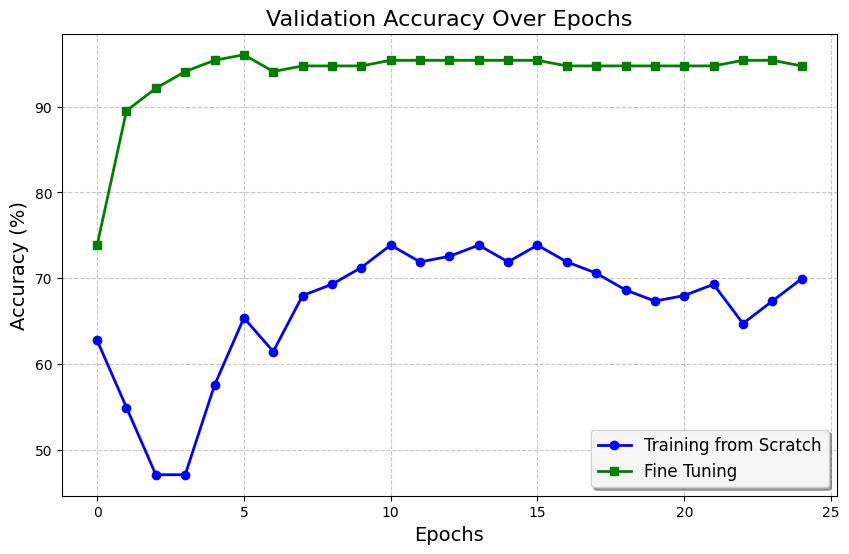

In [56]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)


ax.plot(epochs, 100 * np.array(accs_scratch), color='blue',
        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft), color='green',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)

# Assuming accs_scratch and accs_ft are dictionaries with 'val' as a key
# you can use the following lines
#ax.plot(epochs, 100 * np.array(accs_scratch['val']), color='skyblue',
#        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
#ax.plot(epochs, 100 * np.array(accs_ft['val']), color='lightgreen',
#        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)

# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()

The fine-tuning approach has many variations that fit into the broader framework of **transfer learning**. Partial fine-tuning, as illustrated in the following exercise, is one of these variations.

**Exercise 10:** Instead of retraining all the weights, you can simply use the weights of the classifier. This is referred to as *freezing* the other weights during retraining. \\
Implement this approach and compare it with the previous ones.

In [57]:
resnet = torchvision.models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# freeze all the layers except the classifier (the last dense layers at end)
# using this snippet :

for module in resnet.modules() :
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
    for param in module.parameters():
      param.requires_grad = False


freezed_resnet = resnet.to(device)
# train the model
# ...
# freezed_resnet, accs_freezing = train(...)

In [58]:
optimizer = torch.optim.SGD(freezed_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

freezed_resnet = freezed_resnet.to(device)
freezed_resnet, _, accs_freezing = train_model_gpu_(dataloaders,
                                                freezed_resnet,
                                                loss_function,
                                                optimizer,
                                                num_epochs=max_epochs)

Epoch 0/24
----------
train Loss: 0.7279 Acc: 54.10%
val Loss: 0.6084 Acc: 67.32%
Epoch 1/24
----------
train Loss: 0.6333 Acc: 63.11%
val Loss: 0.5346 Acc: 73.20%
Epoch 2/24
----------
train Loss: 0.5370 Acc: 78.28%
val Loss: 0.4563 Acc: 87.58%
Epoch 3/24
----------
train Loss: 0.4743 Acc: 83.61%
val Loss: 0.3883 Acc: 92.81%
Epoch 4/24
----------
train Loss: 0.4087 Acc: 85.66%
val Loss: 0.3328 Acc: 93.46%
Epoch 5/24
----------
train Loss: 0.3555 Acc: 89.75%
val Loss: 0.2967 Acc: 92.81%
Epoch 6/24
----------
train Loss: 0.3011 Acc: 93.85%
val Loss: 0.2687 Acc: 93.46%
Epoch 7/24
----------
train Loss: 0.2943 Acc: 91.80%
val Loss: 0.2530 Acc: 94.12%
Epoch 8/24
----------
train Loss: 0.3015 Acc: 90.57%
val Loss: 0.2381 Acc: 94.12%
Epoch 9/24
----------
train Loss: 0.2479 Acc: 92.21%
val Loss: 0.2246 Acc: 94.12%
Epoch 10/24
----------
train Loss: 0.2649 Acc: 90.98%
val Loss: 0.2169 Acc: 94.12%
Epoch 11/24
----------
train Loss: 0.2520 Acc: 90.98%
val Loss: 0.2098 Acc: 94.77%
Epoch 12/24
--

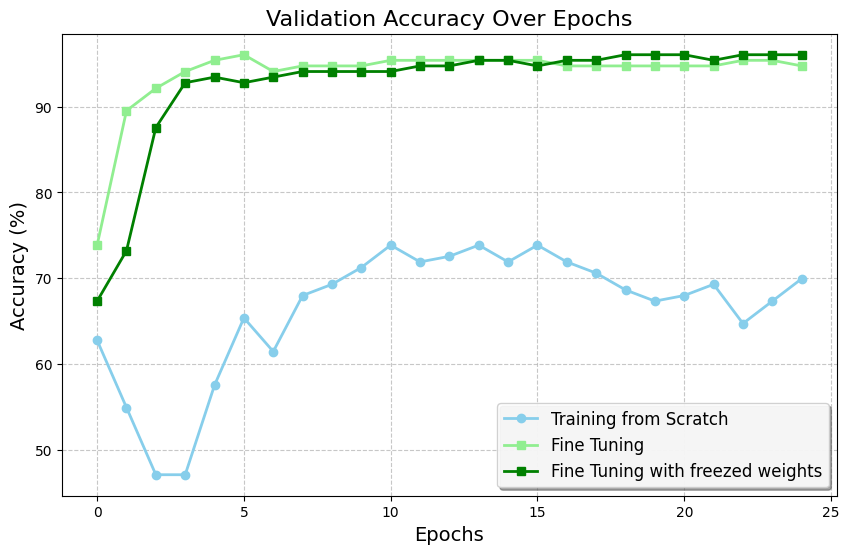

In [59]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the data with improved style
epochs = np.arange(max_epochs)


ax.plot(epochs, 100 * np.array(accs_scratch), color='skyblue',
        label='Training from Scratch', marker='o', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_ft), color='lightgreen',
        label='Fine Tuning', marker='s', linestyle='-', linewidth=2)
ax.plot(epochs, 100 * np.array(accs_freezing), color='g',
        label='Fine Tuning with freezed weights', marker='s', linestyle='-', linewidth=2)


# Set title and axis labels
ax.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)

# Set grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
# Add legend with a border and shadow
ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9, fontsize=12)
plt.show()

In the end, for this small dataset, retraining the last layer performs just as well as global training. To conclude, let's make some predictions with the model on the validation dataset:

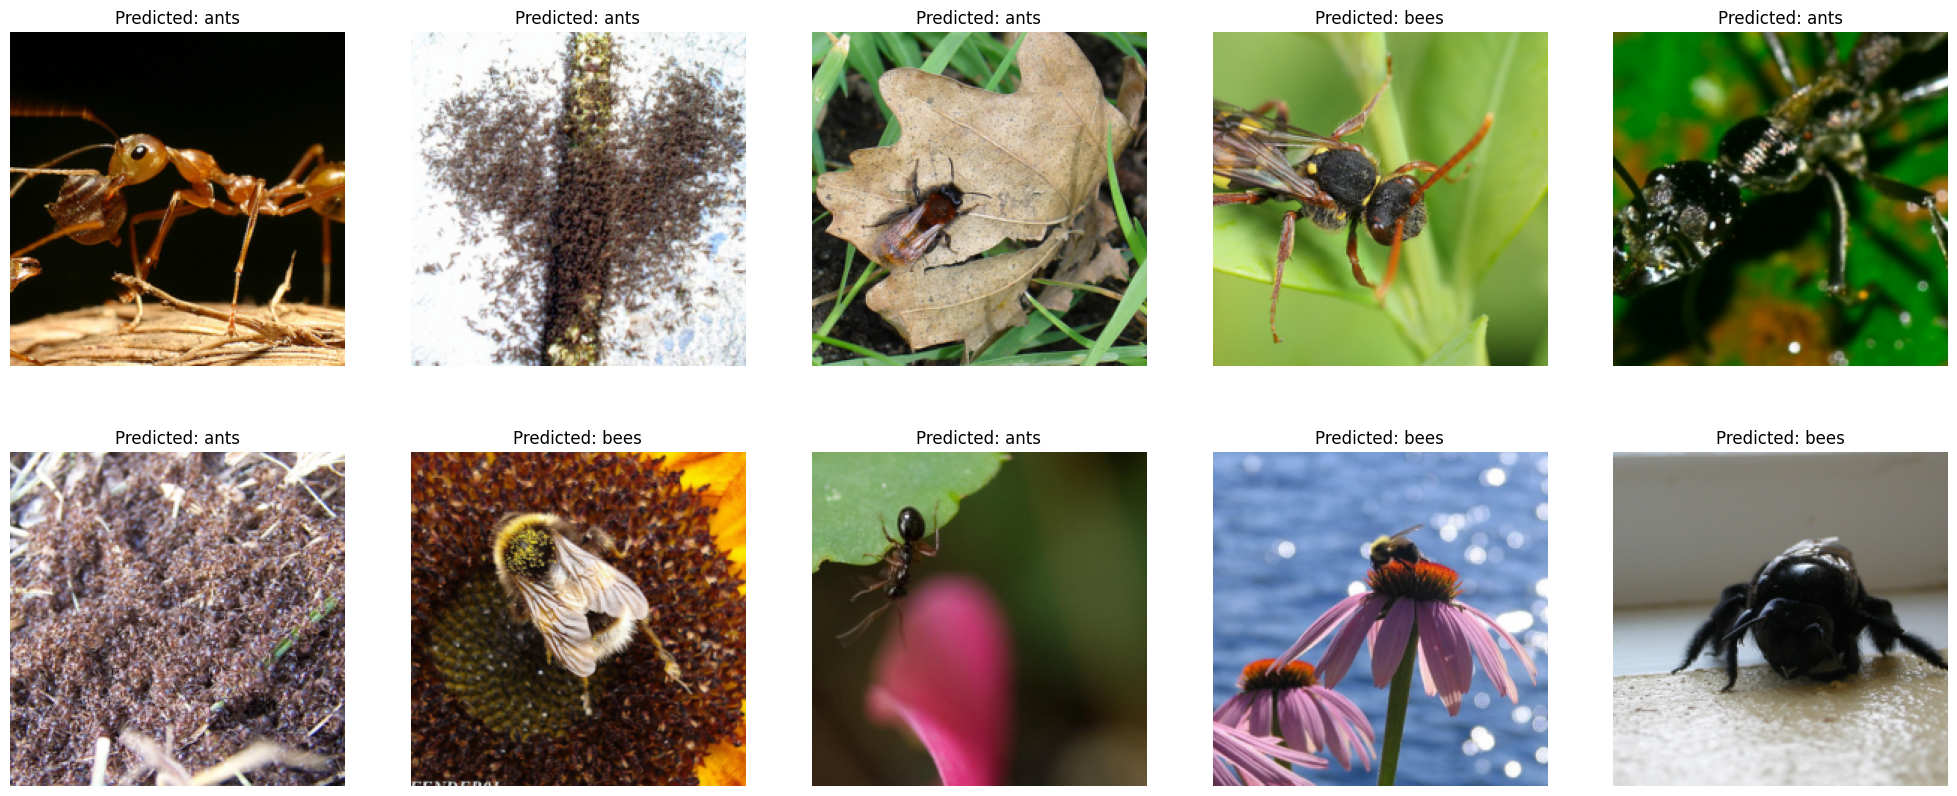

In [61]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25,num_images//5*5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j],ax,'Predicted: {}'.format(class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(resnet_ft, num_images=10)